# TP3

## Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template.

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos

2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1

3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

## Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [12]:
from pathlib import Path
import numpy as np
import supervision as sv
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from typing import Iterator

In [13]:
PATH_MAT = Path("./material")
PATH_IMGS = PATH_MAT / "images"
PATH_TEMPLATE = PATH_MAT / "template" / "pattern.png"

IMGS = {p.name[:-4]:p for p in PATH_IMGS.iterdir()}

MIN_BEST_METHODS = {cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED}

DEFAULT_PLOT_PARAMS = dict(
    fontWidth=1, 
    fontScale=0.35, 
    color='blue'
)

EPS = 1e-8

TEMPLATE = cv.imread(PATH_TEMPLATE)

## Utils

In [14]:
# util para generar color

def str_to_opencv(color: str) -> tuple[int,int,int]:
    rgb = to_rgb(color)
    return tuple(int(255*x) for x in rgb[::-1])


# mostramos para rojo y negro
str_to_opencv('red'), str_to_opencv('black')

((0, 0, 255), (0, 0, 0))

In [15]:
# ploteo de detecciones

def plot_boxes(
        boxes: list[tuple[int,int,int,int]] | np.ndarray,
        scores: list[float] | np.ndarray | None,
        base_img: np.ndarray,
        color: tuple[int,int,int] | str = (0,0,255),
        width: int = 2,
        fontScale: float = 0.35,
        fontWidth: int = 1,
        p: Path | None = None
):
    img_copy = base_img.copy()

    if isinstance(boxes, np.ndarray):
        boxes = boxes.tolist()

    if scores is not None and isinstance(scores,np.ndarray):
        scores = scores.tolist()
    elif scores is None:
        scores = [None] * len(boxes)

    if isinstance(color, str):
        color = str_to_opencv(color)

    for (x1,y1,x2,y2),score in zip(boxes, scores):
        cv.rectangle(img_copy, (x1,y1), (x2,y2), color, width)
        if score is not None:
            label = str(round(score, 3))
            (label_width, label_height), _ = cv.getTextSize(label, 
                                                            cv.FONT_HERSHEY_SIMPLEX, 
                                                            fontScale, fontWidth)

            text_end = (x1 + label_width, y1 - label_height)
            # texto blanco, fondo negro
            cv.rectangle(img_copy, (x1,y1), text_end, (0,0,0),-1)
            cv.putText(img_copy, label, (x1,y1), 
                       cv.FONT_HERSHEY_SIMPLEX, 
                       fontScale, (255,255,255), fontWidth)
    
    if p is None:
        sv.plot_image(img_copy)
    else:
        cv.imwrite(p,img_copy)

In [16]:
# iterador de escalas x aspect_ratio con chequeo de bounds

def scale_iter(
        min_scale: float, 
        max_scale: float, 
        scale_step: float,
        img_shape: tuple[int, int],
        template_shape: tuple[int, int],
        max_aspect_ratio: float,
        aspect_ratio_step: float
    ) -> Iterator[tuple[float,float]]:

    # get ratios
    h_ratio, w_ratio = [u/v for u,v in zip(img_shape, template_shape)]

    # can't make it larger than img ratio
    for scaleX in np.arange(min_scale, 
                            min(max_scale, w_ratio)+EPS, 
                            scale_step):
        
        scalesY = scaleX * np.arange(1/max_aspect_ratio, 
                                     max_aspect_ratio+EPS,
                                     aspect_ratio_step)
        # can't make it larger than img ratio
        for scaleY in scalesY[scalesY <= h_ratio]:
            yield scaleX.item(), scaleY.item()

In [17]:
def multi_detection_2step(
    img_rgb: np.ndarray,
    template: np.ndarray,
    threshold: float = 0,
    top_perc: float = 0.1,
    method: int = cv.TM_CCOEFF_NORMED,
    nms_max_overlap: float = 0.4,
    scale_range: tuple[float, float] = (0.2, 2),
    scale_step: float = 0.1,
    max_aspect_ratio: float = 1.45,
    aspect_ratio_step: float = 0.1,
    canny_thresholds: tuple[int,int] = (100, 200),
    debug: bool = False,
    plot: bool = False,
    plot_params: dict = DEFAULT_PLOT_PARAMS
) -> tuple[list[tuple[int, int, int, int]], list[float]]:
    
    # grayscale both
    img_gs = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
    template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

    # canny on img
    img_edges = cv.Canny(img_gs, *canny_thresholds)

    # if minimizing, do 1-threshold instead
    if method in MIN_BEST_METHODS:
        threshold = 1 - threshold

    # util: process one
    def process_one(scaleX: float, scaleY: float, min_confidence: float | None = None):
        # resize template
        scaled_template = cv.resize(
            template, None, 
            fx=scaleX, fy=scaleY, 
            interpolation=cv.INTER_LINEAR
        ) # type: ignore

        # double check
        h, w = scaled_template.shape
        if img_edges.shape[0] < h or img_edges.shape[1] < w:
            if debug:
                print(f"Scale {scaleX}, {scaleY} out of base image bounds")
            return -1
        
        # canny on resized template
        template_edges = cv.Canny(scaled_template, *canny_thresholds)

        # template matching
        result = cv.matchTemplate(img_edges, template_edges, method)

        # if minimizing, do (1 - metric) instead
        confidences = (1.0 - result) if method in MIN_BEST_METHODS else result

        # no min_confidence <=> we're looking for it <=> round 1
        if min_confidence is None:
            return confidences.max()
        
        # round 2: return indices + confidence scores, given by min_confidence
        # get indices + confidence scores
        mask = confidences >= min_confidence
        match_indices = np.where(mask)
        confidences = confidences[mask]

        if debug:
            print(f"{[round(x,3) for x in (scaleX,scaleY)]}-pre-NMS:{len(match_indices[0])}")

        # double check
        assert len(confidences)>0, f"{(scaleX,scaleY)} in round 2 should have detections"

        return [(x, y, x+w, y+h) for y,x in zip(*match_indices)], confidences.tolist()
            
    # ROUND 1
    # get max for each scale
    scales_max_conf = [
        (scales, process_one(*scales, None))
        for scales in scale_iter(*scale_range, scale_step, 
                                 img_gs.shape, template.shape,
                                 max_aspect_ratio, aspect_ratio_step)
    ]
    max_conf: float = max(b for a,b in scales_max_conf) # type: ignore

    if debug:
        print("Max conf found is", max_conf)
    
    # min_confidence must be within top_perc of max_conf and also >= threshold
    min_confidence = max(max_conf*(1-top_perc), threshold)

    if debug:
        print("Min confidence is:", min_confidence)

    # ROUND 2
    # get detections
    boxes = []
    scores = []
    for scales, conf in scales_max_conf:
        if conf < min_confidence:
            continue
    
        b,c = process_one(*scales, min_confidence)

        boxes.extend(b)
        scores.extend(c)

    # now build detections, apply NMS
    if not boxes:
        # covering case where fixed_threshold >= max_conf
        if debug:
            print("No detections found, best was",max_conf)
        return [], []

    detections = sv.Detections( 
        xyxy=np.array(boxes),
        confidence=np.array(scores)
    )
    detections = detections.with_nms(threshold=nms_max_overlap, class_agnostic=True)
    xyxy = detections.xyxy.tolist()
    confidences = detections.confidence.tolist()

    if plot:
        plot_boxes(xyxy, confidences, img_rgb, **plot_params)
    
    return xyxy, confidences

# Pruebas sobre las imágenes

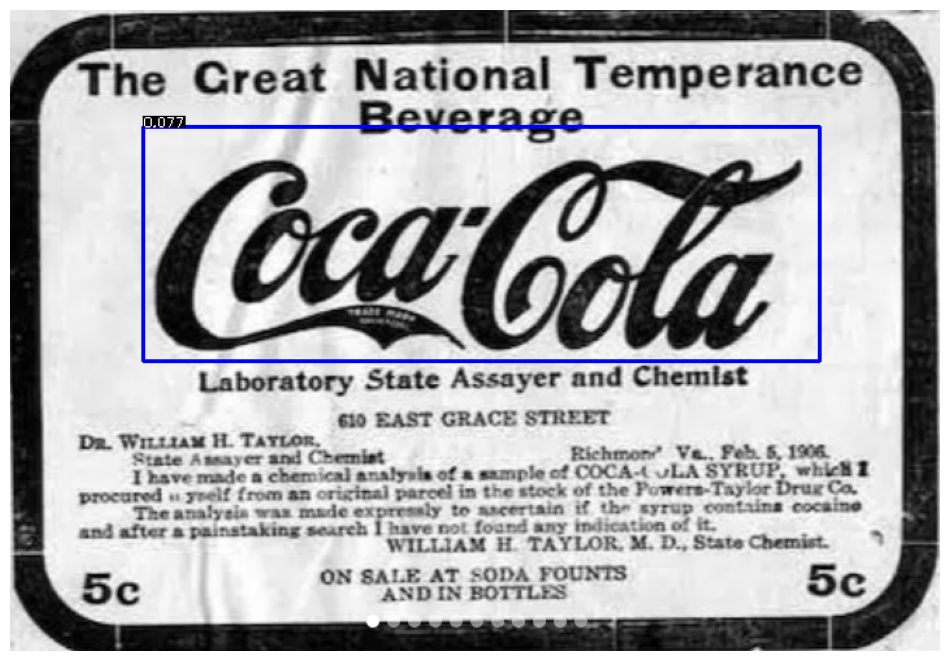

In [18]:
dets, scores = multi_detection_2step(
    cv.imread(IMGS['coca_retro_1']),
    TEMPLATE,
    scale_range=(1,2),
    plot=True,
)

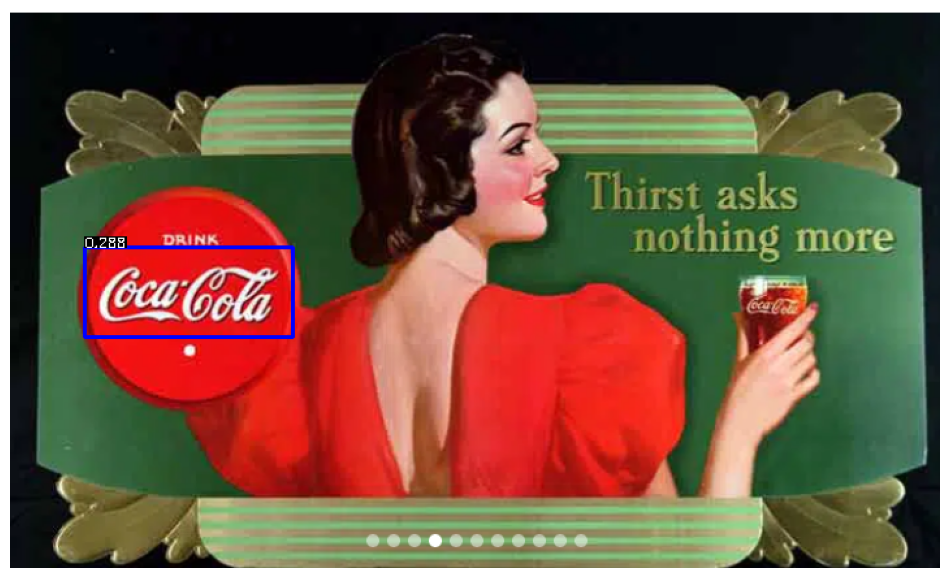

In [19]:
dets, scores = multi_detection_2step(
    cv.imread(IMGS['coca_retro_2']),
    TEMPLATE,
    plot=True,
)

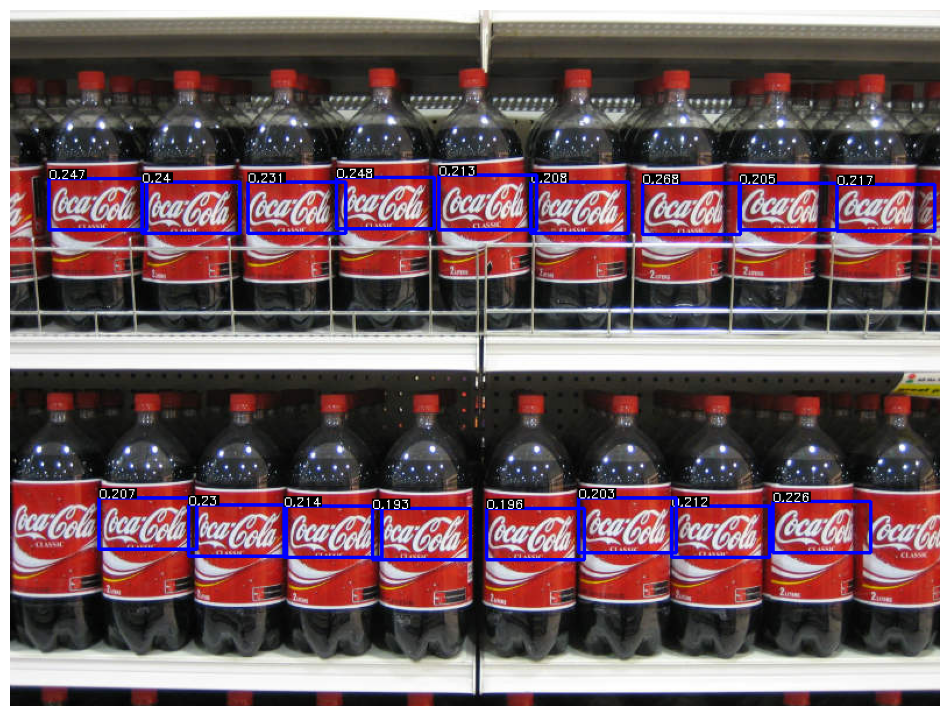

In [20]:
dets, scores = multi_detection_2step(
    cv.imread(IMGS['coca_multi']),
    TEMPLATE,
    top_perc=0.3,
    scale_range=(0.21,10),
    plot=True,
)

Comentario: se mantienen dos falsos negativos.

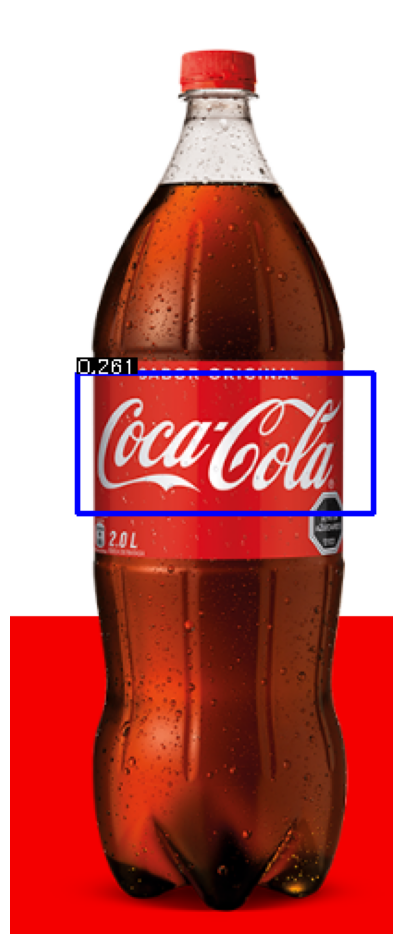

In [21]:
dets, scores = multi_detection_2step(
    cv.imread(IMGS['coca_logo_1']),
    TEMPLATE,
    plot=True,
)

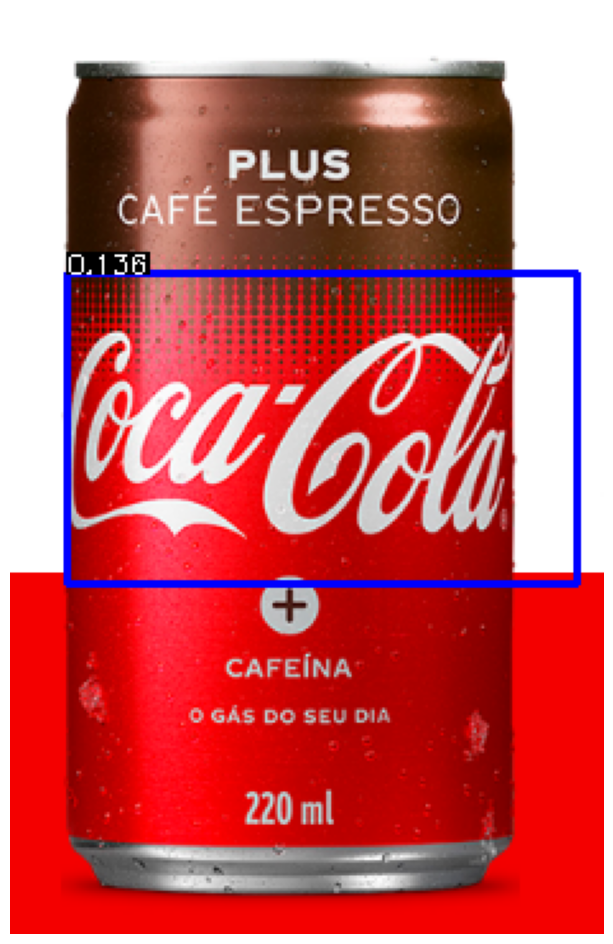

In [22]:
dets, scores = multi_detection_2step(
    cv.imread(IMGS['coca_logo_2']),
    TEMPLATE,
    scale_range=(0.5,2),
    plot=True,
)

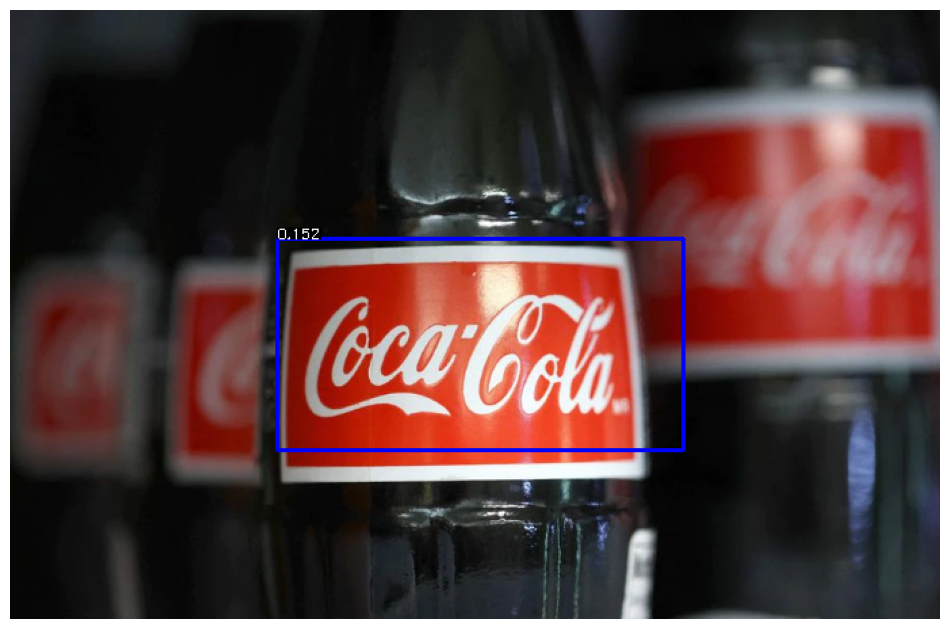

In [23]:
dets, scores = multi_detection_2step(
    cv.imread(IMGS['logo_1']),
    TEMPLATE,
    scale_range=(0.75,2),
    plot=True,
)

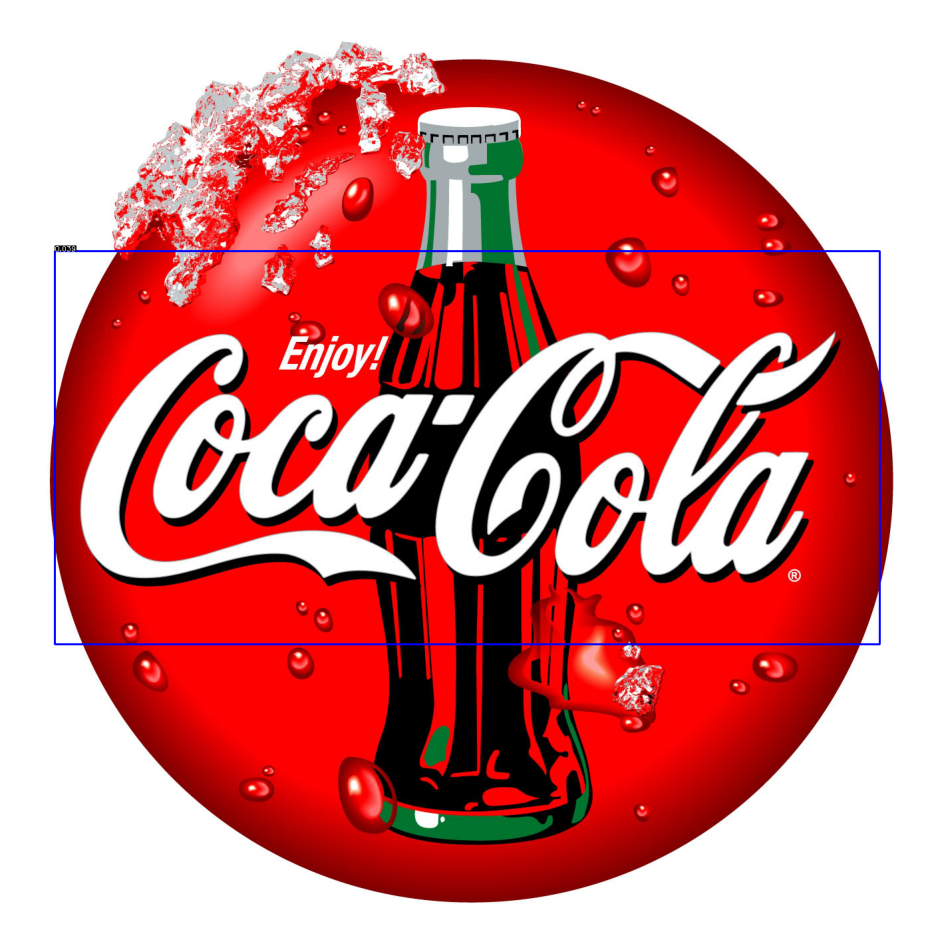

In [24]:
dets, scores = multi_detection_2step(
    cv.imread(IMGS['COCA-COLA-LOGO']),
    TEMPLATE,
    scale_range=(3,10),
    plot=True,
)

Como comentario extra, en particular para la imagen de multi detección, el método `CCORR_NORMED` es más estable, solo necesitando modificar el `top_perc` y obviando falsos positivos que con `CCOEF_NORMED` aparecen si no se modifica el rango de escalas:

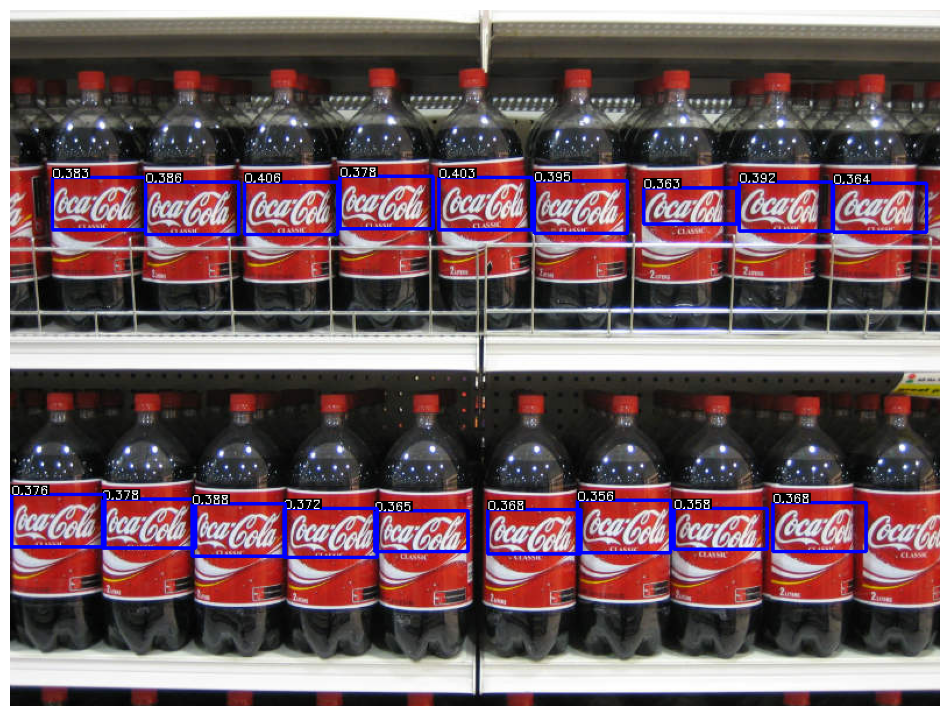

In [25]:
dets, scores = multi_detection_2step(
    cv.imread(IMGS['coca_multi']),
    TEMPLATE,
    top_perc=0.125,
    method=cv.TM_CCORR_NORMED,
    plot=True,
)

Estos métodos de template matching son muy susceptibles a deformaciones del texto, cambios de iluminación y especialmente a cuestiones de escala. Da la impresión de que uno necesita saber aproximadamente sobre qué escala (y aspect ratio) está realizando la búsqueda para evitar falsos positivos de "correlaciones espurias". Todas estas observaciones apuntan en la dirección del uso de métodos como SIFT.

Dicho eso, se logró implementar un algoritmo que con muy pocos ajustes en los parámetros realiza multi-detección sobre todas las imágenes presentadas, cumpliendo los 3 puntos de la consigna al mismo tiempo.